https://adventofcode.com/2022/day/24

In [1]:
import numpy as np
from dataclasses import dataclass, field
from typing import Self
from utilities import xy_array_as_string
from typing import Optional

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import clear_output

blizzard_mapping = {'^': np.array([0,-1]),
                    'v': np.array([0,1]),
                    '<': np.array([-1,0]),
                    '>': np.array([1,0])}

inv_blizzard_mapping = {(1,0): 2,
                        (0,1): 3,
                        (-1,0): 4,
                        (0,-1): 5}

@dataclass
class Path():
    target: tuple
    loc: np.ndarray=field(default_factory=lambda: np.array([1,0]))
    visited: list[tuple[int, int]]=field(init=False)
        
    def __post_init__(self) -> None:
        self.visited = [tuple(self.loc)]
        
    @property
    def remaining_distance(self) -> int:
        return np.sum(np.abs(np.array(self.target) - self.loc))
    
    def copy(self) -> Self:
        new_path = Path(target=self.target)
        new_path.loc = self.loc.copy()
        new_path.visited = self.visited.copy()
        return new_path
    
    def move(self,
            loc: np.ndarray) -> None:
        self.loc = loc
        self.visited.append(tuple(loc))
        
    def complete(self) -> bool:
        return tuple(self.loc) == self.target
    
    @property
    def minutes(self):
        return len(self.visited) - 1
    
    def __lt__(self,
               other: Self):
        return self.remaining_distance < other.remaining_distance
    
@dataclass
class Blizzard():
    loc: np.ndarray
    velocity: np.ndarray
    lims: tuple[int, int]
    movement_axis: int=field(init=False)
        
    def __post_init__(self) -> None:
        self.movement_axis = np.where(self.velocity != 0)[0][0]
        
    def move(self) -> None:
        self.loc = self.loc + self.velocity
        if self.loc[self.movement_axis] == self.lims[0]:
            self.loc[self.movement_axis] = self.lims[1]

path_moves = np.array([[0,0],
                       [1,0],
                       [-1,0],
                       [0,1],
                       [0,-1]])
@dataclass
class Valley():
    data: np.ndarray
    blizzards: list[Blizzard]=field(init=False)
    paths: list[Path]=field(init=False)
    blocked: set[tuple[int, int]]=field(init=False)
    _state: Optional[np.ndarray]=None
        
    def __post_init__(self) -> None:
        self.blizzards = []
        self.paths = [Path(target=self.path_end)]
        self.blocked = set(map(tuple, np.array(np.where(self.data == 1)).T))
        self._state = self.state()
        
    def update_blizzards(self) -> None:
        for b in self.blizzards:
            b.move()
        self._state = None
                            
    @property
    def path_start(self) -> tuple:
        return (1,0)
    
    @property
    def path_end(self) -> tuple:
        return (self.data.shape[0]-2, self.data.shape[1]-1)

    @classmethod
    def from_input_data(cls,
                        data: np.ndarray[str]) -> Self:
        int_data = np.zeros_like(data, dtype=int)
        int_data[np.where(data == '#')] = 1
        x_max, y_max = np.array(int_data.shape) - 1
        valley = cls(int_data)
        for s, v in blizzard_mapping.items():
            match s:
                case '^': lims = (0, y_max-1)
                case 'v': lims = (y_max, 1)
                case '<': lims = (0, x_max-1)
                case '>': lims = (x_max, 1)
            for l in np.array(np.where(data == s)).T:
                valley.blizzards.append(Blizzard(loc=l,
                                                 velocity=v,
                                                 lims = lims))
        return valley
       
    def state(self,
              elves=False) -> np.ndarray:
        if (self._state is None) or (elves is True):
            self._state = self.data.copy()
            for b in self.blizzards:
                self._state[tuple(b.loc)] = inv_blizzard_mapping[tuple(b.velocity)]
            if elves:
                for e in self.paths:
                    self._state[tuple(e.loc)] = 6
        return self._state
    
    def show(self) -> str:
        return xy_array_as_string(self.state(elves=True),
                                  {0: '.',
                                   1: '#',
                                   2: '>',
                                   3: 'v',
                                   4: '<',
                                   5: '^',
                                   6: 'E'})
                                  
    def update_paths(self,
                     prune: Optional[int]=50) -> None:
        paths_at_next_step = []
        locs_at_next_step = set()
        while self.paths:
            p = self.paths.pop(0)
            for move in path_moves:
                next_loc = p.loc + move
                if tuple(next_loc) not in self.blocked:
                    if tuple(next_loc) not in locs_at_next_step:
                        if self.can_move(next_loc):
                            pn = p.copy()
                            pn.move(next_loc)
                            locs_at_next_step.add(tuple(next_loc))
                            paths_at_next_step.append(pn)
        if prune:
            self.paths = sorted(paths_at_next_step)[:prune]
        else:
            self.paths = paths_at_next_step
                               
    def can_move(self,
                loc: np.array) -> bool:
        if (np.any(loc < 0)) or (np.any(loc > np.array(self.data.shape) - 1)):
            return False
        return self.state()[tuple(loc)] == 0
    
    def display(self) -> None:
        clear_output(wait=True)
        mat = valley.state(elves=True).T
        mat[np.where(np.bitwise_and(mat > 1, mat < 6))] = 2
        plt.matshow(mat)
        plt.axis('off')
        plt.show()
        
    def quickest_path(self,
                      start: tuple[int, int],
                      end: tuple[int, int],
                      prune: Optional[int]=None,
                      display: bool=False) -> Path:
        self.paths = [Path(loc=np.array(start), target=end)]
        while not np.any([p.complete() for p in valley.paths]):
            self.update_blizzards()
            self.update_paths(prune=prune)
            if display: self.display()
        return next(p for p in valley.paths if p.complete())

def read_data(filename: str) -> str:
    with open(filename, 'r') as f:
        data = [list(line.strip()) for line in f.readlines()]
    return np.array(data).T

In [2]:
# part 1

filename = "../data/day24_data.txt"
data = read_data(filename)
valley = Valley.from_input_data(data)
quickest_path = valley.quickest_path(valley.path_start, valley.path_end)
print(quickest_path.minutes)

305


In [3]:
# part 2

prune = 50
display = False

filename = "../data/day24_data.txt"
data = read_data(filename)
valley = Valley.from_input_data(data)
quickest_path = valley.quickest_path(valley.path_start,
                                     valley.path_end,
                                     prune=prune,
                                     display=display)
m1 = quickest_path.minutes
quickest_path = valley.quickest_path(valley.path_end,
                                     valley.path_start,
                                     prune=prune,
                                     display=display)
m2 = quickest_path.minutes
quickest_path = valley.quickest_path(valley.path_start,
                                     valley.path_end,
                                     prune=prune,
                                     display=display)
m3 = quickest_path.minutes
print(m1 + m2 + m3)

905


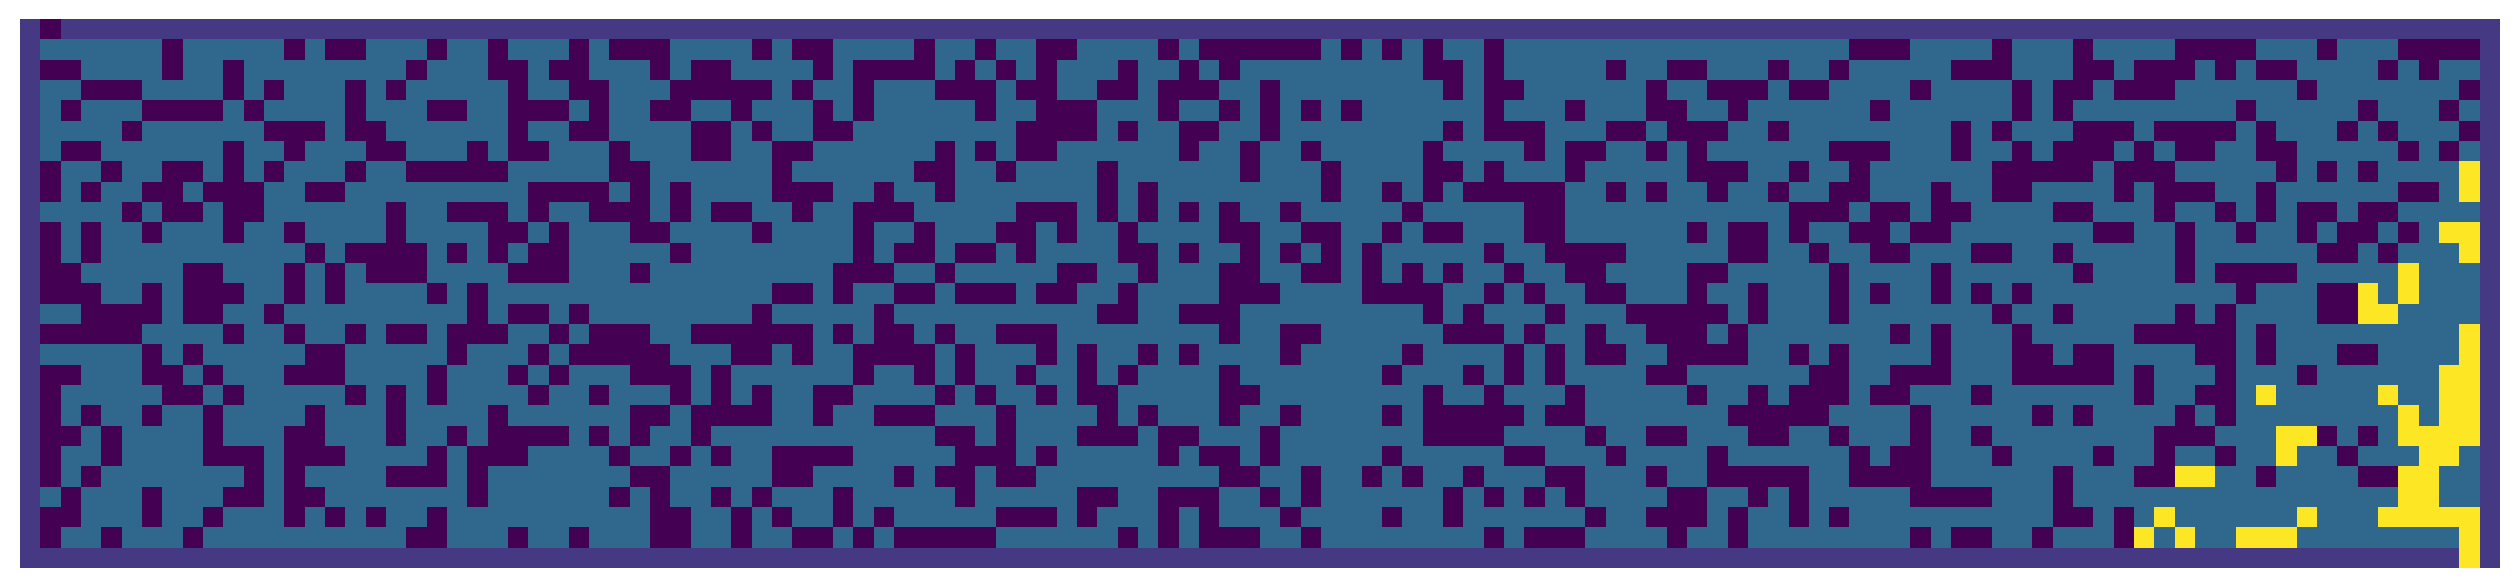

905


In [4]:
# part 2, with visualisation

prune = 50
display = True

filename = "../data/day24_data.txt"
data = read_data(filename)
valley = Valley.from_input_data(data)
quickest_path = valley.quickest_path(valley.path_start,
                                     valley.path_end,
                                     prune=prune,
                                     display=display)
m1 = quickest_path.minutes
quickest_path = valley.quickest_path(valley.path_end,
                                     valley.path_start,
                                     prune=prune,
                                     display=display)
m2 = quickest_path.minutes
quickest_path = valley.quickest_path(valley.path_start,
                                     valley.path_end,
                                     prune=prune,
                                     display=display)
m3 = quickest_path.minutes
print(m1 + m2 + m3)